In [61]:
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

torch.__version__

'2.0.1+cu117'

Data link : https://www.kaggle.com/datasets/jangedoo/utkface-new


### Preprocessing Our Raw Data
1. Creating dataframe for our features

In [62]:
import os

dir = 'UTKFace'
files = [filename for filename in os.listdir(dir)]

data = {'path' : files}

df = pd.DataFrame(data)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    23708 non-null  object
dtypes: object(1)
memory usage: 185.3+ KB


The features for this dataset is provided in the filename itself `[age]_[gender]_[race]_[date&time].jpg`

In [63]:
## adding extra features to our dataframe

temp = []
for x in df['path']:
    temp.append(x.split('_'))


temp = pd.DataFrame(temp)

columns = ['age','gender','race','date']

temp.columns = columns

temp



,age,gender,race,date
0,50,0,0,20170117135034485.jpg.chip.jpg
1,55,0,3,20170119171117830.jpg.chip.jpg
2,12,0,4,20170103201607807.jpg.chip.jpg
3,40,0,0,20170117172519480.jpg.chip.jpg
4,39,1,3,20170104233629347.jpg.chip.jpg
...,...,...,...,...
23703,65,0,0,20170111200641250.jpg.chip.jpg
23704,26,1,0,20170116234741431.jpg.chip.jpg
23705,55,0,0,20170120140655585.jpg.chip.jpg
23706,60,1,0,20170110122614299.jpg.chip.jpg


In [64]:
df = pd.concat([temp,df],axis = 1)

df = df.drop(['date'],axis =1) #unnecessary feature

df

,age,gender,race,path
0,50,0,0,50_0_0_20170117135034485.jpg.chip.jpg
1,55,0,3,55_0_3_20170119171117830.jpg.chip.jpg
2,12,0,4,12_0_4_20170103201607807.jpg.chip.jpg
3,40,0,0,40_0_0_20170117172519480.jpg.chip.jpg
4,39,1,3,39_1_3_20170104233629347.jpg.chip.jpg
...,...,...,...,...
23703,65,0,0,65_0_0_20170111200641250.jpg.chip.jpg
23704,26,1,0,26_1_0_20170116234741431.jpg.chip.jpg
23705,55,0,0,55_0_0_20170120140655585.jpg.chip.jpg
23706,60,1,0,60_1_0_20170110122614299.jpg.chip.jpg


## From MetaData we have following information

1. `[age]`is an integer from 0 to 116, indicating the age
2. `[gender]` is either 0 (male) or 1 (female)
3. `[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

In [7]:
# Creating index map for race

race_mapping = {0:'White',
       1:'Black',
       2:'Asian',
       3:'Indian',
       4:'Others'}


### Visualizing Data

<Axes: xlabel='age', ylabel='Density'>

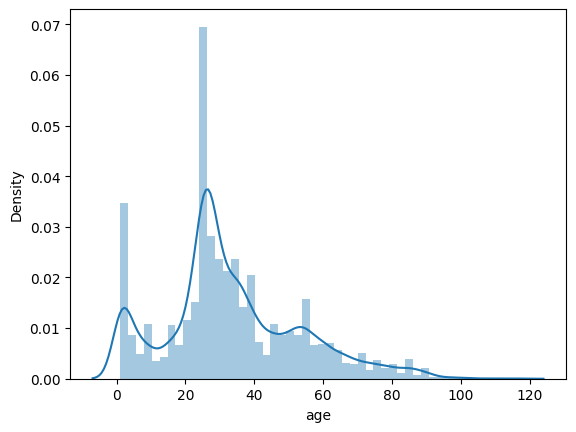

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#Let's visualize age category first
sns.distplot(df['age'])

race
0                                 10078
1                                  4526
3                                  3975
2                                  3434
4                                  1692
20170116174525125.jpg.chip.jpg        1
20170109150557335.jpg.chip.jpg        1
20170109142408075.jpg.chip.jpg        1
Name: count, dtype: int64


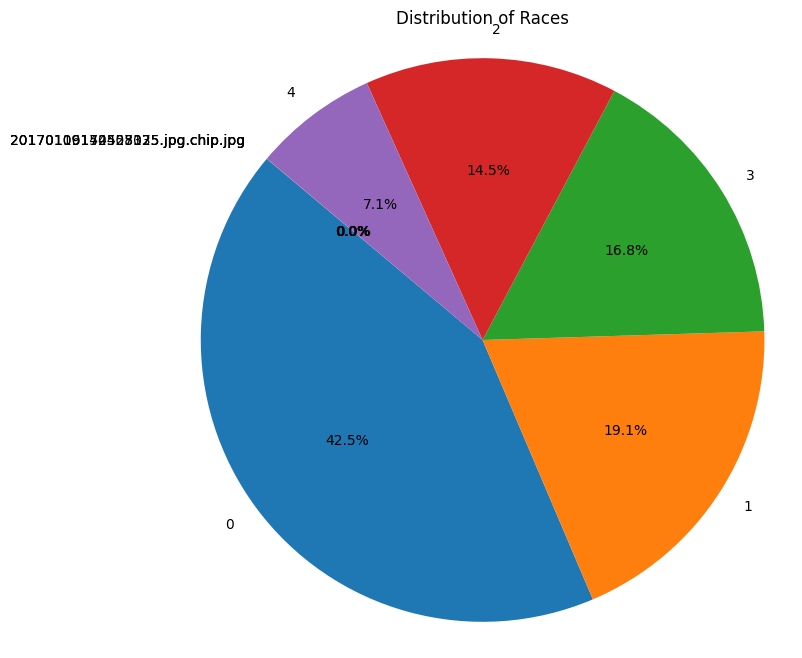

In [9]:
# delete abnormal rows || task to be assigned


race_counts = df['race'].value_counts()

print(race_counts)

plt.figure(figsize=(8, 8))
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Races')
plt.show()


gender
0    12391
1    11317
Name: count, dtype: int64


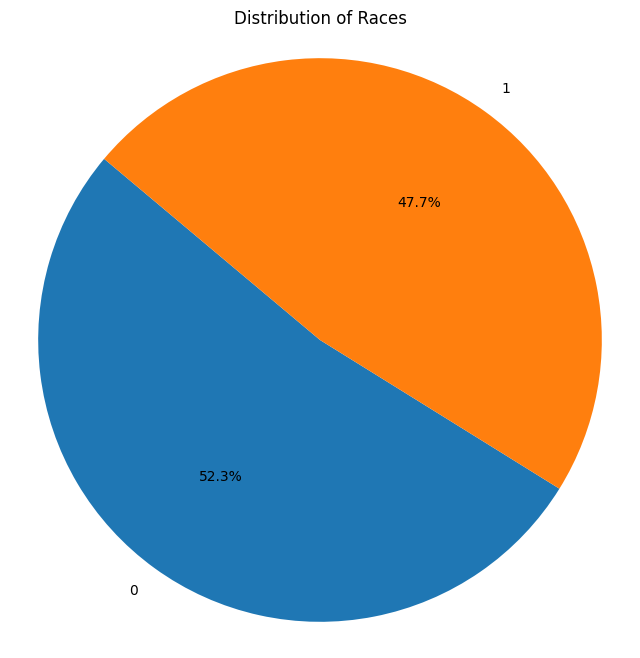

In [10]:
# Make meaningful diagram || task to be assigned

age_counts = df['gender'].value_counts()

print(age_counts)

plt.figure(figsize=(8, 8))
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Races')
plt.show()

In [11]:
import cv2

In [12]:
!pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable


In [13]:
import cv2


image_dir = 'UTKFace'

image_arrays = []

for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):  

        img = cv2.imread(os.path.join(image_dir, filename))
        
        if img is not None:
            image_arrays.append(img)


image_array = np.array(image_arrays)

print("Shape of the NumPy array:", image_array.shape)


Shape of the NumPy array: (23708, 200, 200, 3)


In [14]:
#Converting dataset into numpy array

X = df.drop(['path'],axis =1).to_numpy()
y = image_array


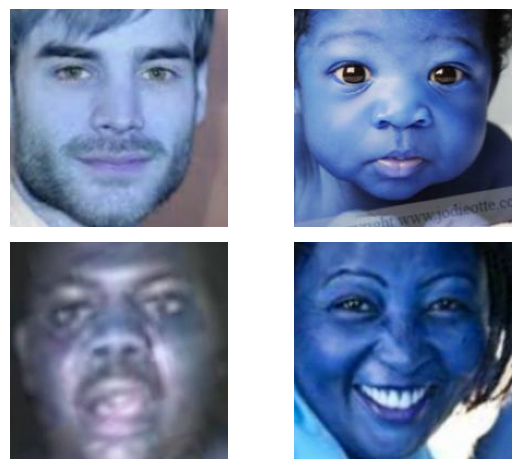

In [35]:
# Visualizing 5 random samples from y

randnums = np.random.randint(0, y.shape[0], 4)

fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(y[randnums[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [102]:
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image


class CustomDataset(Dataset):

    def __init__(self,path,labels,transfrom=None):
        self.img_dir = path
        self.img_labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_labels.iloc[idx,3])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image,label

# Here normalization component was a standard found from the internet

transform = transforms.Compose([  
    transforms.ToPILImage(),
    transforms.ToTensor(),   
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

In [103]:
custom_dataset = CustomDataset('UTKFace', df, transform)
custom_dataset

In [104]:
from torch.utils.data import DataLoader

batch_size = 32
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


In [107]:
next(iter(data_loader))[0].shape # Test column

torch.Size([32, 3, 200, 200])